In [1]:
import pickle
import numpy as np
import pandas as pd
import pyplot_themes as themes
import matplotlib.pyplot as plt
from seaborn import palplot
from IPython.display import clear_output

themes.theme_minimal()

import data_loader
sample = data_loader.get_events_sample(size=30)

# The CREAM dataset

In [2]:
# Problem: Most components yet unlabeled -> no ground truth available
all_component_events = data_loader.get_component_events(filter=False)
pd.DataFrame(all_component_events.Component.value_counts())

,Component
unlabeled,89989
heater,1988
pump,260
millingplant,212


In [3]:
# Problem: Less off than on events -> can't really use to determine end of samples
all_component_events = all_component_events[all_component_events.Component != 'unlabeled']
pd.DataFrame(all_component_events.Event_Type.value_counts())

,Event_Type
On,1499
Off,961


In [4]:
# Used samples
all_component_events = all_component_events[all_component_events.Event_Type == 'On']
pd.DataFrame(all_component_events.Component.value_counts())

,Component
heater,1027
pump,260
millingplant,212


In [5]:
# Which days?
for component in ['heater', 'millingplant', 'pump']:
    part = all_component_events[all_component_events.Component == component]
    print(component)
    print(part.Timestamp.dt.dayofweek.value_counts())

heater
5    962
3     22
4     17
1     13
2     11
0      2
Name: Timestamp, dtype: int64
millingplant
3    57
0    55
4    41
1    37
2    22
Name: Timestamp, dtype: int64
pump
4    81
1    63
0    44
3    39
2    33
Name: Timestamp, dtype: int64


# Preprocessing

## Periods of nonactivity in the CREAM dataset (component events)

Using a sample from the complete dataset, we can manually look at the intervals of inactivity:

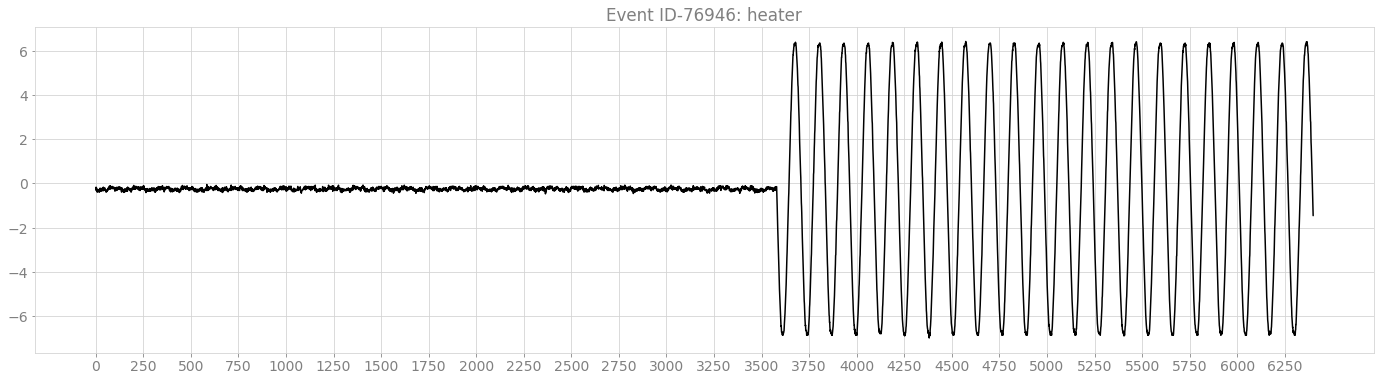

Sampling points until start of activity:
3600


In [6]:
offsets = []
for event, (voltage, current) in sample:
    clear_output()
    plt.figure(figsize=(24,6))
    plt.title(f"Event ID-{event.ID}: {event.Component}")
    plt.plot(current[:6400])
    plt.xticks(np.arange(0, 6400, 250))
    plt.show()
    offsets.append(int(input("Sampling points until start of activity:\n")))

In [7]:
df = pd.DataFrame({
    'Q1': np.quantile(offsets, 0.25),
    'median': np.median(offsets), 'mean': np.mean(offsets),
    'Q2': np.quantile(offsets, 0.75),
    'std': np.std(offsets)
}, index=['manual sample'])
df.round()

,Q1,median,mean,Q2,std
manual sample,0.0,1775.0,1967.0,3550.0,1862.0


Analyzing our results, it is clear that many component events have periods of inactivity - some of which are concerningly large. Thus, we need to evaluate the effect of removing these offsets from our measurements.

## Automatic offsetting

If we define nonactivity as current measurements with absolute values smaller than 1A (a more than reasonable assumption looking at our sample), we can easily identify the actual start of events.

In [8]:
# Apply automatic offset correction to sample and collect statistics
voltage = np.vstack(tuple(map(lambda x: x[1][0], sample)))
current = np.vstack(tuple(map(lambda x: x[1][1], sample)))
_, _, offsets = data_loader.offset_correct(voltage, current)
df.loc['automatic sample'] = (
    np.quantile(offsets, 0.25), np.median(offsets), np.mean(offsets),
    np.quantile(offsets, 0.75), np.std(offsets)
)

In [9]:
# Apply automatic offset correction to complete dataset and collect statistics
all_component_events = data_loader.get_component_events()
voltage, current, y = data_loader.read_dataset(
    all_component_events, start_offset=0, duration=4
)
_, _, event_offsets, period_offsets = data_loader.preprocess(
    voltage, current, 50, offsets=True
)
df.loc['automatic all'] = (
    np.quantile(event_offsets, 0.25), np.median(event_offsets),
    np.mean(event_offsets), np.quantile(event_offsets, 0.75),
    np.std(event_offsets)
)

100.0%

If we compare these offsets to the sample we looked at manually, our automatic approach seems viable:

In [10]:
df.round()

,Q1,median,mean,Q2,std
manual sample,0.0,1775.0,1967.0,3550.0,1862.0
automatic sample,0.0,1776.0,1991.0,3540.0,1915.0
automatic all,1079.0,2827.0,2603.0,3960.0,1800.0


Let's also have a look at how the automatic offset correction works by looking at the results visually!

Event ID-77154: heater


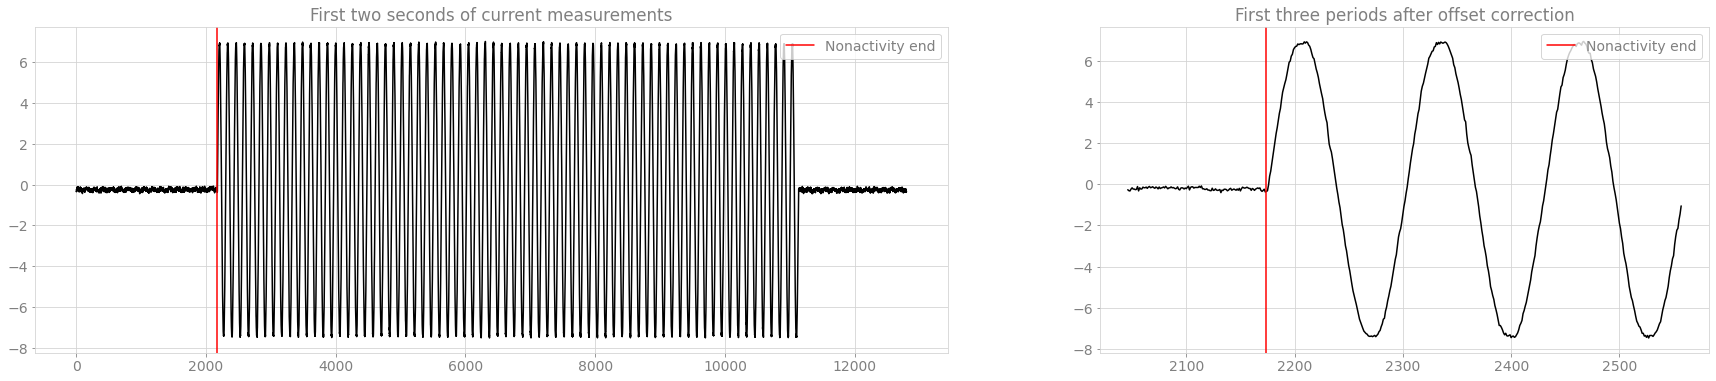

Event ID-32047: millingplant


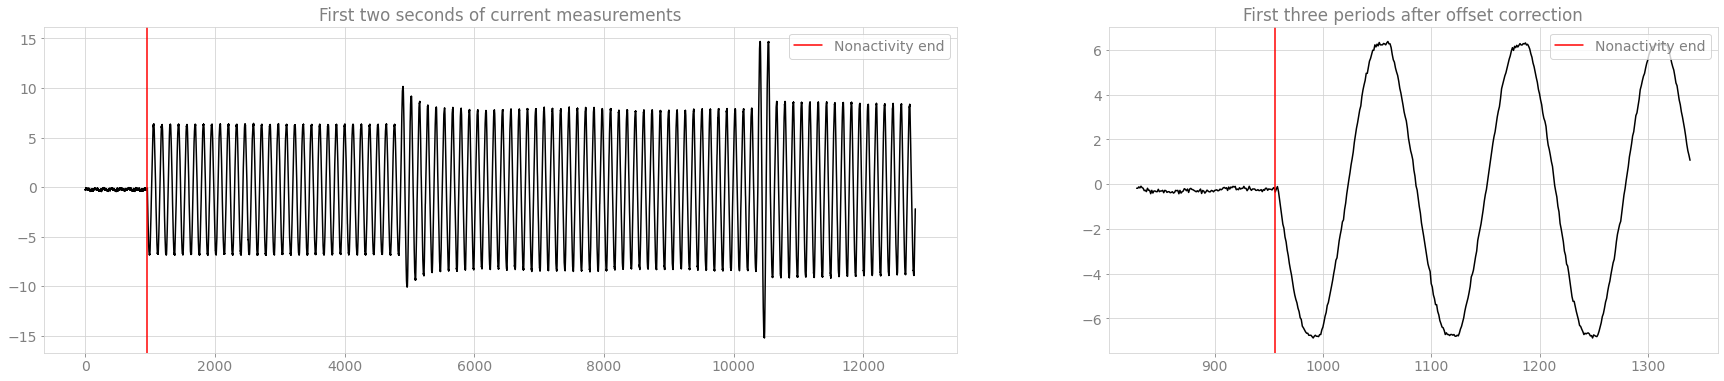

Event ID-3579: pump


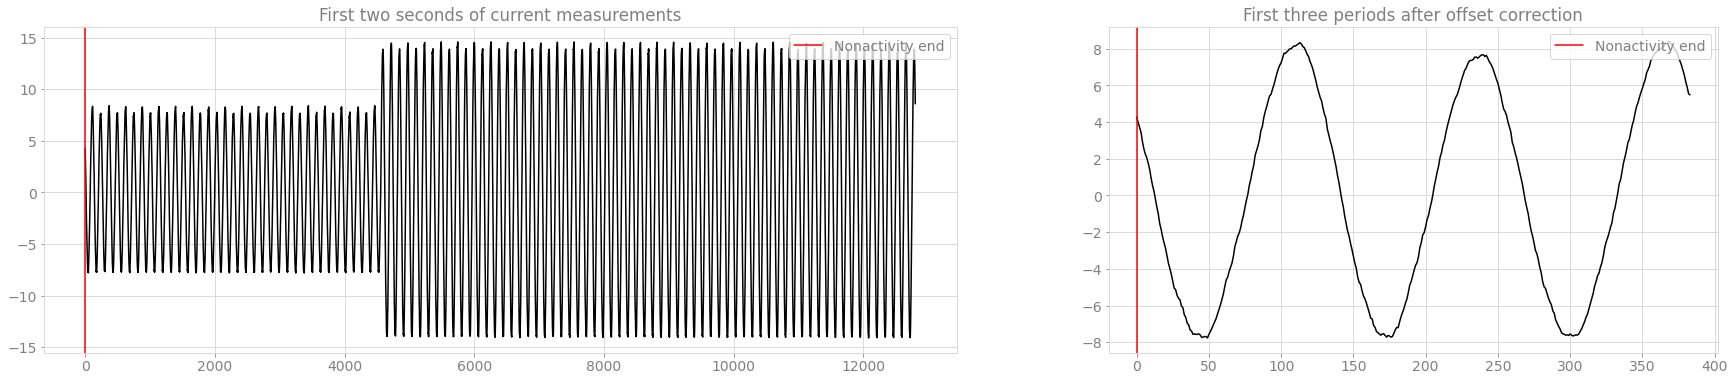

In [11]:
for event, (s_voltage, s_current) in sample[:3]:
    print("Event ID-{}: {}".format(event.ID, event.Component))

    _, _, offset = data_loader._offset_correct_single(s_voltage, s_current, 50)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30,6),
                                   gridspec_kw={'width_ratios': [3,2]})
    
    # Big overview plot
    ax0.plot(s_current[:2*6400])
    ax0.axvline(offset, c='r', label="Nonactivity end")
    ax0.set_title("First two seconds of current measurements")
    ax0.legend(loc='upper right')

    # Detailed plot to showcase offset accuracy
    detail_start = max(0, offset - 128)
    detail_end = min(s_current.shape[0], offset + 3*128)
    ax1.plot(np.arange(s_current.shape[0])[detail_start:detail_end],
             s_current[detail_start:detail_end])
    ax1.axvline(offset, c='r', label="Nonactivity end")
    ax1.set_title("First three periods after offset correction")
    ax1.legend(loc='upper right')

    plt.show()

## Alignment with rising zero crossing

As some features require the measurements to be aligned to rising zero-crossings anyways, the decision was made to test the effect of this alignment on all features. Again, we can do this automatically: While there are definitely many possible approaches, the easiest way is to base the required offset on the indices of the negative current measurement after which a positive one follows.

Event ID-77154: heater


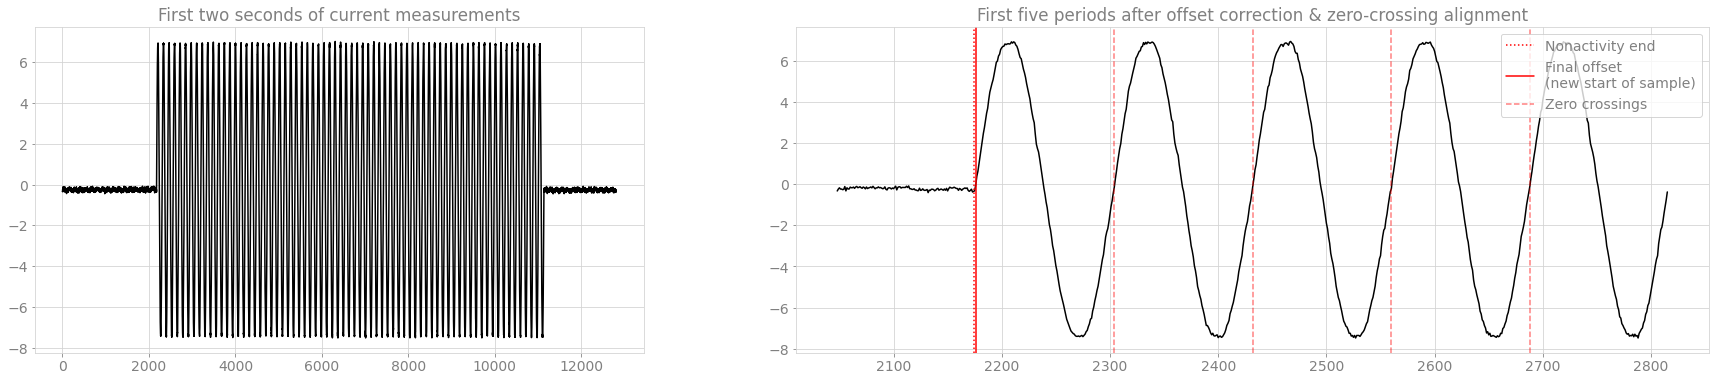

Event ID-32047: millingplant


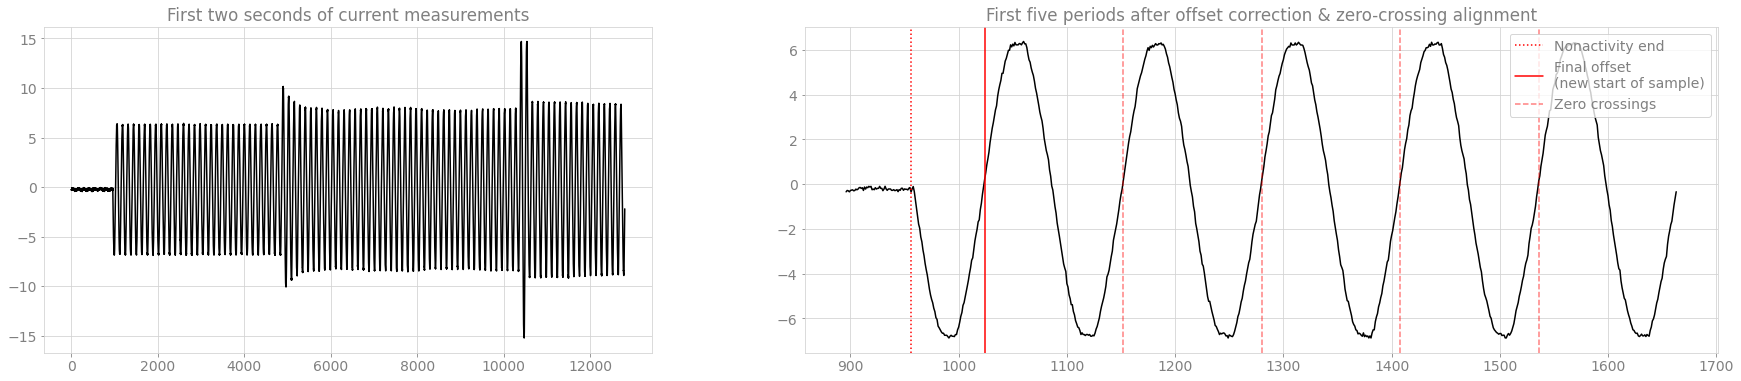

Event ID-3579: pump


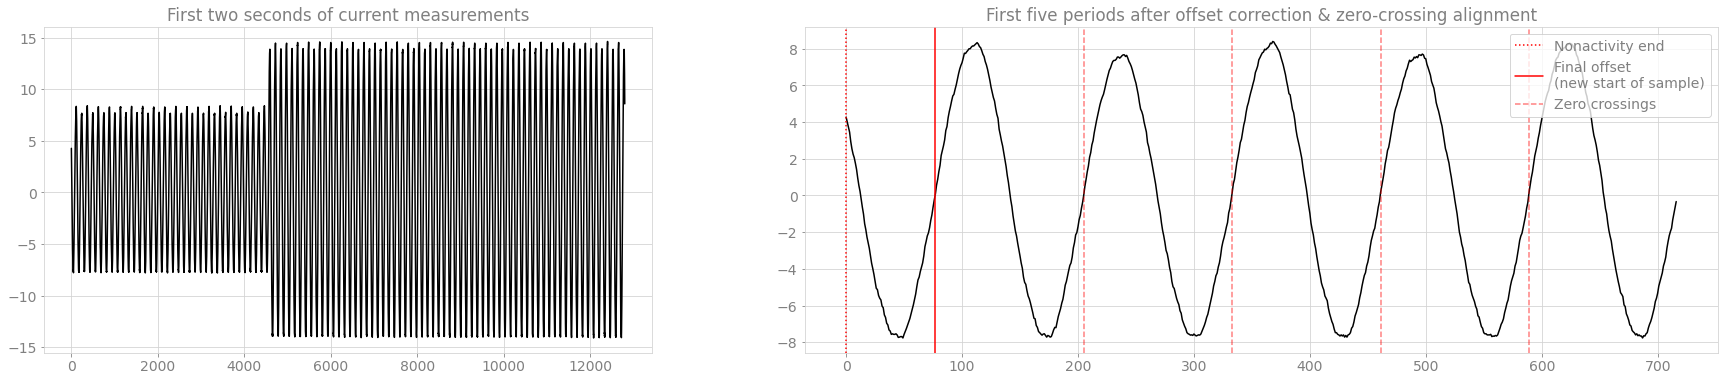

In [12]:
for event, (s_voltage, s_current) in sample[:3]:
    print("Event ID-{}: {}".format(event.ID, event.Component))

    v, i, act_offset = data_loader._offset_correct_single(s_voltage, s_current, 51)
    _, _, period_offset = data_loader._synchronize_period_single(v, i, 50)
    combined_offset = act_offset + period_offset

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30,6),
                                   gridspec_kw={'width_ratios': [2,3]})
    
    # Big overview plot
    ax0.plot(s_current[:2*6400])
    ax0.set_title("First two seconds of current measurements")

    # Detailed plot to showcase offset accuracy
    detail_start = max(0, combined_offset - 128)
    detail_end = min(s_current.shape[0], combined_offset + 5*128)
    ax1.set_title("First five periods after offset correction & zero-crossing alignment")
    ax1.plot(np.arange(s_current.shape[0])[detail_start:detail_end],
             s_current[detail_start:detail_end])
    ax1.axvline(act_offset, label="Nonactivity end", c='r', ls=':')
    ax1.axvline(combined_offset, label="Final offset\n(new start of sample)", c='r')
    for i in range(1, 5):
        ax1.axvline(combined_offset + i*128,
                    label="Zero crossings" if i == 1 else '',
                    c='r', alpha=0.5, ls='--')
    ax1.legend(loc='upper right')

    plt.show()

    if event.ID == 32047:
        fig.savefig('../thesis/figures/methology_preprocessing.pdf',
                    bbox_inches='tight')

## Effect of preprocessing on classification performance

In [13]:
# Reusing voltage and current measurements for complete dataset from "Automatic offseting"
non_voltage, non_current = voltage[:, :6400], current[:, :6400]
offset_voltage, offset_current, _ = data_loader.offset_correct(voltage, current, 50)
aligned_voltage, aligned_current, _ = data_loader.synchronize_period(voltage, current, 50)
pre_voltage, pre_current = data_loader.preprocess(voltage, current, 50)

# Calculate features based on the different current & voltage samples
from features.helpers import get_all_features, feature_evaluation
non_features = get_all_features(non_voltage, non_current)
offset_features = get_all_features(offset_voltage, offset_current)
aligned_features = get_all_features(aligned_voltage, aligned_current)
pre_features = get_all_features(pre_voltage, pre_current)

feature_collections = {
    'no preprocessing': non_features, 'non-activity removal only': offset_features,
    'zero-crossing alignment': aligned_features, 'both': pre_features
}

In [21]:
df = pd.DataFrame(columns=('collection', 'feature', 'score'))

# Evaluate all features
for collection_name in feature_collections:
    for feature in feature_collections[collection_name]:
        score = feature_evaluation(feature_collections[collection_name][feature],
                                   y, output=False)
        df.loc[len(df)] = (collection_name, feature, score)
        # Progress report
        clear_output()
        print(f"{feature} ({collection_name}): {round(score, 2)}")

# Join no preprocessing part of df with rest on feature column
df = df[df.collection == 'no preprocessing'].join(
    df[df.collection != 'no preprocessing'].set_index('feature'),
    on='feature', how='outer', lsuffix='_no', rsuffix='_pre'
)

# Improvement is difference between feature score before and after preprocessing step
df['improvement'] = df['score_pre'] - df['score_no']

Wavelet transform energy over time (voltage) (both): 0.59


In [22]:
df.groupby('collection_pre').mean()

,score_no,score_pre,improvement
collection_pre,,,
both,0.580187,0.752363,0.172176
non-activity removal only,0.580187,0.744032,0.163845
zero-crossing alignment,0.580187,0.606965,0.026778


# Sample lengths

In [23]:
import feature_selection
from data_loader import get_component_events, read_dataset, preprocess
from features.helpers import get_all_features
PERIOD_LENGTH = 128

all_component_events = get_component_events()
__voltage, __current, y = read_dataset(all_component_events, start_offset=0, duration=9.5)

ts = all_component_events.Timestamp
diffs = (ts.diff()  / np.timedelta64(1, 's')).astype('float64')[1:]

100.0%

In [24]:
df = pd.DataFrame(columns=['aoi', 'model', 'features', 'score', 'estimator'])

for i, aoi in enumerate(np.arange(25, 251, 25)):
    _voltage, _current = preprocess(__voltage, __current, aoi)
    print(f"\n\nTrying out length of {aoi} periods")
    features = get_all_features(_voltage, _current)
    n_features = feature_selection.normalize_features(features)
    for model in ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']:
        best = feature_selection.simple_stepwise_regression(n_features, y, model, max=1)
        df.loc[len(df)] = [aoi, model, best.features, best.score, best.estimator]



Trying out length of 25 periods
    change_type                                             change     score
9   addition of                      Harmonics energy distribution  0.883014
30  addition of                               Harmonics (first 20)  0.881054
27  addition of                                        Current RMS  0.877698
55  addition of                               Admittance over time  0.873101
18  addition of                                  Current over time  0.871793
24  addition of                          Total harmonic distortion  0.868843
2   addition of       Wavelet transform energy over time (current)  0.866660
21  addition of                                      VI Trajectory  0.858582
32  addition of                             Waveform approximation  0.857478
53  addition of                                        Tristimulus  0.842764
41  addition of                                     Reactive power  0.826481
51  addition of                           

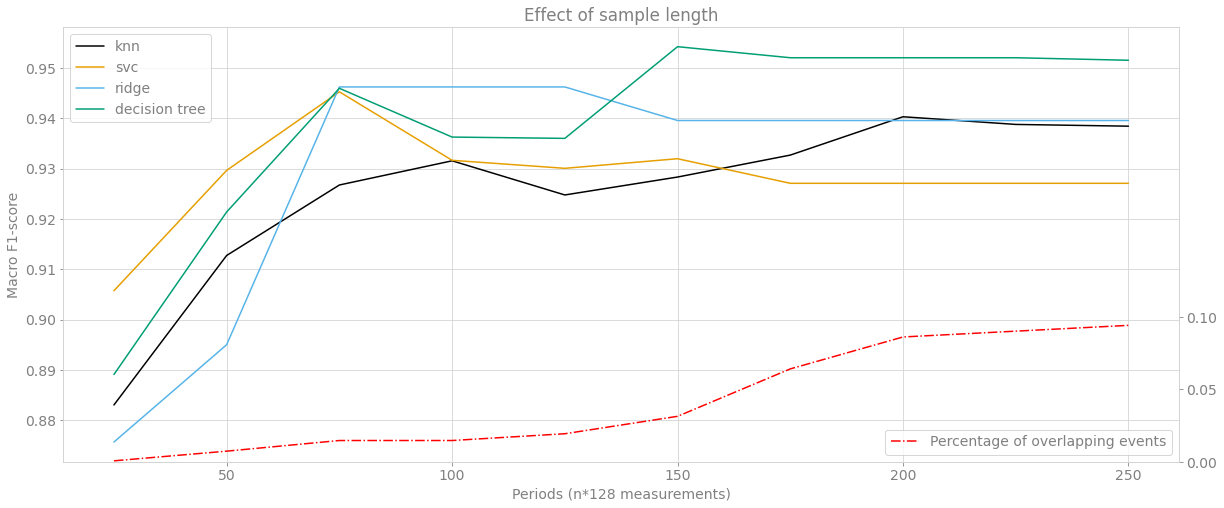

In [25]:
fig, ax1 = plt.subplots(figsize=(20, 8))
for model in ['knn', 'svc', 'ridge', 'decision_tree']:
    sub_df = df[df['model'] == model]
    ax1.plot(sub_df.aoi, sub_df.score, label=model.replace('_', ' '))
ax1.set_title("Effect of sample length")
ax1.set_xlabel("Periods (n*128 measurements)")
ax1.set_ylabel("Macro F1-score")
ax1.legend()

ax2 = ax1.twinx()                   # Create ax with new y-axis but same x-axis
x = np.arange(0.5, 5.01, 0.5)
l = [np.sum(diffs < x) / len(diffs) for x in x]
ax2.plot(x*50, l, linestyle='dashdot', c='r',
         label="Percentage of overlapping events")
ax2.set_ylim(0.0, 0.3)              # Force percentage to lower third of plot
ax2.grid(None)                      # Two grids look ugly
ax2.set_yticks((0.00, 0.05, 0.1))   # No ticks for forced (ylim) values
ax2.legend(loc='lower right')
plt.show()

fig.savefig('../thesis/figures/methology_sample_lengths.pdf', bbox_inches='tight')